In [1]:
!pip install d2l

In [2]:
from collections import defaultdict  # 'defaultdict' modülü, bir sözlük türü sağlar. Eğer anahtar yoksa varsayılan bir değer döner.
import numpy as np  # 'numpy' modülü, bilimsel hesaplamalar ve vektörizasyon işlemleri için kullanılır.
from scipy import stats  # 'scipy' modülü, istatistiksel fonksiyonlar ve bilimsel hesaplamalar sağlar.
from d2l import torch as d2l  # 'd2l' modülü, derin öğrenme uygulamaları için araçlar içerir. PyTorch ile entegrasyonu sağlar.

d2l.set_figsize()  # Grafiklerin boyutunu varsayılan değeriyle ayarlamak için d2l modülünün fonksiyonu çağrılır.


In [3]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):  # Successive Halving Scheduler sınıfı d2l.HPOScheduler sınıfından türetilir.
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):  # Başlangıç parametreleri
        self.save_hyperparameters()  # Hiperparametreleri kaydeder
        # K değeri hesaplanır; bu değer, yapılandırma sayısını belirlemek için kullanılır
        self.K = int(np.log(r_max / r_min) / np.log(eta))  # r_max ve r_min arasındaki oranı eta ile logaritmik olarak hesaplar
        # Rung seviyeleri tanımlanır (adımlar arası değerler)
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]  # r_min'den başlayarak rung seviyeleri belirlenir
        if r_max not in self.rung_levels:
            # Son rung seviyesinin r_max olması gerektiği kontrol edilir
            self.rung_levels.append(r_max)  # r_max rung seviyesine eklenir
            self.K += 1  # K değeri artırılır
        # Error (hata) verilerini saklamak için veri yapıları
        self.observed_error_at_rungs = defaultdict(list)  # Hata verilerini saklamak için defaultdict kullanılır
        self.all_observed_error_at_rungs = defaultdict(list)  # Tüm hata verilerini saklamak için başka bir defaultdict
        # İşlem sırası için kuyruk tanımlanır
        self.queue = []  # Kuyruk başlatılır


In [4]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # SuccessiveHalvingScheduler sınıfına yeni bir fonksiyon ekler.
def suggest(self):
    if len(self.queue) == 0:  # Kuyruk boşsa yeni bir halving turuna başla
        # İlk rung için yapılandırma sayısı:
        n0 = int(self.prefact * self.eta ** self.K)  # n0, yapılandırma sayısını hesaplar
        for _ in range(n0):  # n0 kadar yapılandırma oluşturulacak
            config = self.searcher.sample_configuration()  # Arama fonksiyonundan yeni bir yapılandırma alınır
            config["max_epochs"] = self.r_min  # max_epochs değeri r_min olarak ayarlanır
            self.queue.append(config)  # Kuyruğa yeni yapılandırma eklenir
    # Kuyruktan bir öğe döndürülür
    return self.queue.pop()  # Kuyruğun son öğesini çıkarıp döndürür


In [5]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # SuccessiveHalvingScheduler sınıfına yeni bir metod ekler.
def suggest(self):
    if len(self.queue) == 0:  # Eğer kuyruk boşsa, yeni bir halving turu başlatılır.
        # İlk rung için yapılandırma sayısını hesaplar.
        n0 = int(self.prefact * self.eta ** self.K)  # n0, yapılandırma sayısını hesaplar.
        for _ in range(n0):  # n0 kadar yapılandırma örneği oluşturulur.
            config = self.searcher.sample_configuration()  # Yeni bir yapılandırma örneği alınır.
            config["max_epochs"] = self.r_min  # max_epochs r_min olarak ayarlanır.
            self.queue.append(config)  # Yapılandırma kuyruğa eklenir.
    return self.queue.pop()  # Kuyruğun sonundaki öğe döndürülür.


In [6]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # SuccessiveHalvingScheduler sınıfına 'update' fonksiyonu ekleniyor.
def update(self, config: dict, error: float, info=None):
    ri = int(config["max_epochs"])  # r_i rung seviyesini alır (max_epochs parametresi üzerinden).

    # Arama fonksiyonu güncelleniyor, örneğin daha sonra Bayesyen optimizasyonu kullanılabilir.
    self.searcher.update(config, error, additional_info=info)

    # Hata bilgisi, belirli rung seviyelerinde saklanır.
    self.all_observed_error_at_rungs[ri].append((config, error))

    if ri < self.r_max:  # Eğer şu anki rung, maksimum rung seviyesinden küçükse
        # Gözlemler yapılır ve hata bilgileri kaydedilir.
        self.observed_error_at_rungs[ri].append((config, error))

        # Bu rung seviyesinde kaç yapılandırma değerlendirileceği belirlenir.
        ki = self.K - self.rung_levels.index(ri)
        ni = int(self.prefact * self.eta ** ki)

        # Eğer bu rung seviyesindeki tüm yapılandırmalar gözlemlendiyse, en iyi performans gösteren yapılandırmalar seçilir.
        if len(self.observed_error_at_rungs[ri]) >= ni:
            kiplus1 = ki - 1
            niplus1 = int(self.prefact * self.eta ** kiplus1)

            # En iyi performans gösteren yapılandırmalar alınır ve bir üst rung seviyesine geçiş için kuyruğa eklenir.
            best_performing_configurations = self.get_top_n_configurations(
                rung_level=ri, n=niplus1
            )
            riplus1 = self.rung_levels[self.K - kiplus1]  # r_{i+1} rung seviyesi

            # Kuyruk boş olmamalıdır: yeni yapılandırmalar başa eklenir
            self.queue = [
                dict(config, max_epochs=riplus1)
                for config in best_performing_configurations
            ] + self.queue

            # Bu rung seviyesindeki gözlemler sıfırlanır.
            self.observed_error_at_rungs[ri] = []


In [7]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # SuccessiveHalvingScheduler sınıfına 'get_top_n_configurations' fonksiyonu ekler.
def get_top_n_configurations(self, rung_level, n):
    rung = self.observed_error_at_rungs[rung_level]  # Belirtilen rung seviyesindeki gözlemleri alır.

    if not rung:  # Eğer rung boşsa, boş bir liste döndürür.
        return []

    # Gözlemleri hata değerine göre sıralar (artık sıralama yapılır).
    sorted_rung = sorted(rung, key=lambda x: x[1])

    # En iyi n yapılandırmayı döndürür.
    return [x[0] for x in sorted_rung[:n]]  # Sıralı yapılandırmalardan en iyi n tanesini alır.


In [8]:
min_number_of_epochs = 2  # Eğitimdeki minimum epoch sayısı (başlangıç değeri)
max_number_of_epochs = 10  # Eğitimdeki maksimum epoch sayısı (maksimum limit)
eta = 2  # Azaltma oranı, her rung'da değerlendirecek yapılandırma sayısını azaltır

# Konfigürasyon alanı
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),  # Öğrenme oranı logaritmik olarak 0.01 ile 1 arasında rastgele seçilecek
    "batch_size": stats.randint(32, 256),  # Batch boyutu 32 ile 256 arasında rastgele seçilecek
}

# Başlangıç yapılandırması
initial_config = {
    "learning_rate": 0.1,  # Başlangıç öğrenme oranı
    "batch_size": 128,  # Başlangıç batch boyutu
}


    error = 0.17672407627105713, runtime = 268.2501697540283


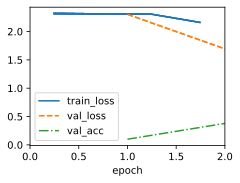

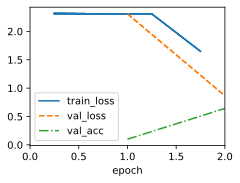

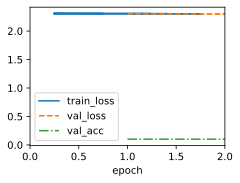

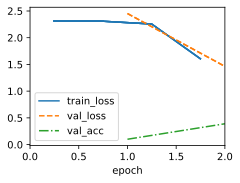

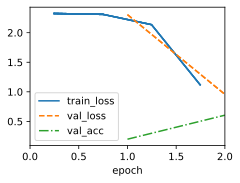

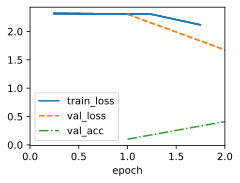

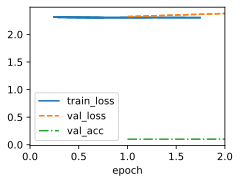

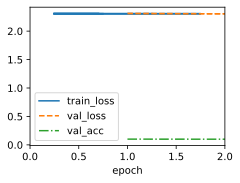

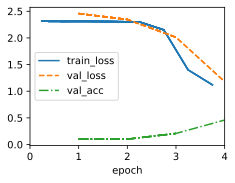

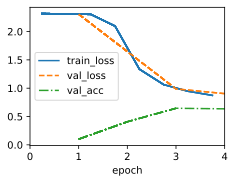

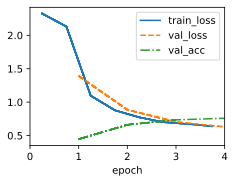

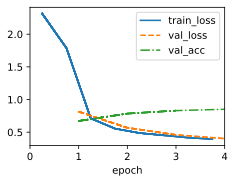

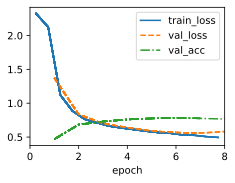

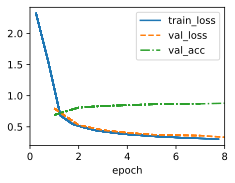

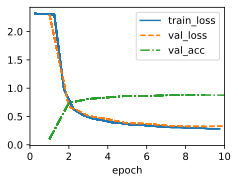

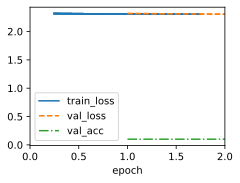

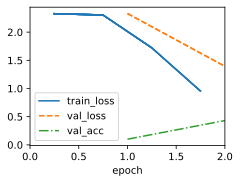

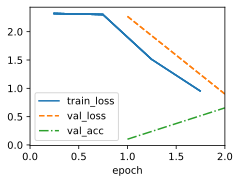

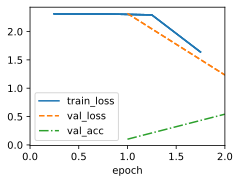

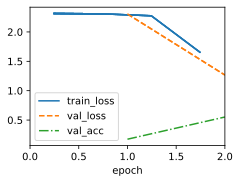

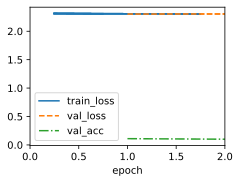

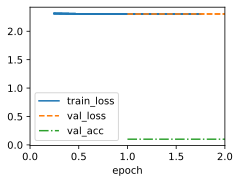

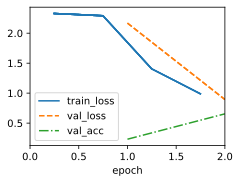

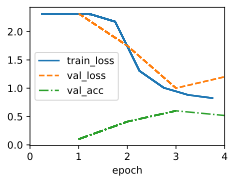

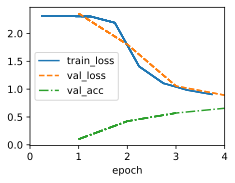

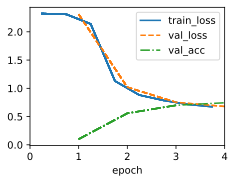

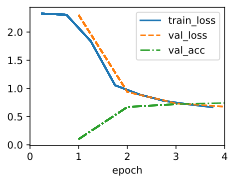

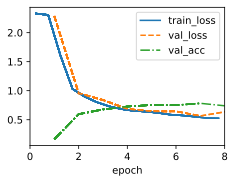

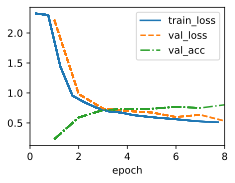

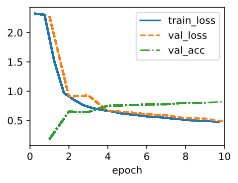

In [10]:
# RandomSearcher, config_space içinde belirtilen hiperparametre aralıklarında rastgele arama yapacak bir arama stratejisidir.
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config)

# SuccessiveHalvingScheduler, Successive Halving algoritmasını kullanarak hiperparametre aramasını yönetecek.
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,  # Arama stratejisi olarak searcher'ı kullanır
    eta=eta,  # Azaltma oranı
    r_min=min_number_of_epochs,  # Başlangıç epoch sayısı
    r_max=max_number_of_epochs,  # Maksimum epoch sayısı
)

# HPOTuner, hiperparametre optimizasyonunu yönetir ve objective fonksiyonunu kullanarak denemeleri yapar.
tuner = d2l.HPOTuner(
    scheduler=scheduler,  # Scheduler'ı kullanarak optimizasyonu yapar
    objective=d2l.hpo_objective_lenet,  # Kullanılacak objective fonksiyonu
)

# 30 deneme ile tuner'ı çalıştırır.
tuner.run(number_of_trials=30)


Text(0.5, 0, 'epochs')

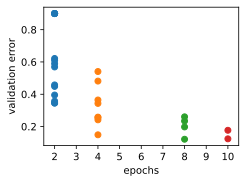

In [11]:
# Her rung seviyesi için gözlemlenen hata değerlerini alır ve görselleştirir
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    # Her rung için hataları alır (rung'daki her öğe: (config, error))
    errors = [xi[1] for xi in rung]
    # Rung seviyesinde hata değerlerini scatter plot ile gösterir
    d2l.plt.scatter([rung_index] * len(errors), errors)

# x ekseninin sınırlarını belirler, epoch sayıları arasında hizalar
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)
# x ekseninde her epoch sayısı için etiketler ekler
d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1)
)
# Y eksenine etiket ekler (validation error)
d2l.plt.ylabel("validation error")
# X eksenine etiket ekler (epochs)
d2l.plt.xlabel("epochs")
